In [2]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from six.moves import cPickle
from sklearn.decomposition import TruncatedSVD
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
%matplotlib inline

In [3]:
df_bus = pd.read_csv('business.csv')

In [4]:
df_full = pd.read_csv('review.csv')

/Applications/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# a.Number of businesses in each city

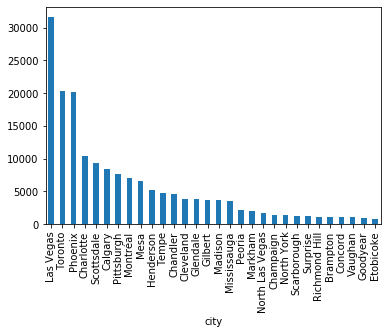

In [15]:
df_bus_groups = df_bus.groupby('city').count()
df_bus_city = df_bus_groups['business_id']
df_bus_city_sorted = df_bus_city.sort_values(ascending = False)
df_bus_city_sorted[:30].plot(kind = 'bar')

Maybe here we can do some data cleaning, like: Toronto, toronto (NLP)

# b.Different type of businesses and their count

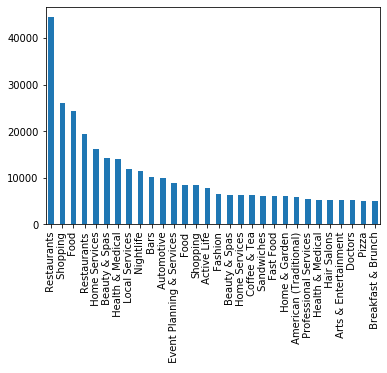

In [18]:
uniq_cat_dict = {}
for i in df_bus.categories:
    cat = str(i).split(',')
    for j in cat:
        if j not in uniq_cat_dict.keys():
            uniq_cat_dict[j] = 1
        else:
            uniq_cat_dict[j] += 1
uniq_cat_series = pd.Series(uniq_cat_dict)
uniq_cat_series.sort_values(ascending = False, inplace = True)
uniq_cat_series[:30].plot(kind = 'bar')

NLP - spacing behind the comma

# c.Business and city ordered pairs and their count

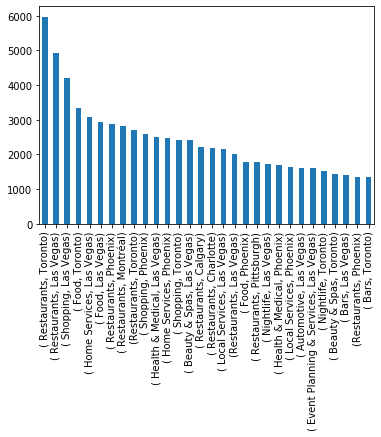

In [22]:
business_city = {}
n = len(df_bus)
for i in range(n):
    k1 = str(df_bus.categories.iloc[i]).split(',')
    k2 = df_bus.city.iloc[i]
    for j in k1:
        k = (j,k2)
        if k not in business_city.keys():
            business_city[k] = 1
        else:
            business_city[k] += 1
business_city_series = pd.Series(business_city)
business_city_series.sort_values(ascending = False, inplace = True)
business_city_series[:30].plot(kind = 'bar')

Inference from a, b, and c : It can be seen that most of the businesses listed on the Yelp are Restaurants, Shopping places and Home Services. For this given data set (obtained from Yelp's Website), top cities with maximum businesses are Las Vegas, Phoenix, and Toronto.

# d.Merging the business data with the review data (on business_id)

In [ ]:
df_reduced = df_full.drop([df_full.columns[0]], axis = 1)
df_reduced.head()

In [29]:
df_merged = df_reduced.merge(df_bus[['city','categories', 'business_id']], how = 'outer', on= 'business_id')
df_merged.head()

,user_id,business_id,rating,date,text,city,categories
0,OwjRMXRC0KyPrIlcjaXeFQ,-MhfebM0QIsKt87iDN-FNw,2.0,2015-04-15 05:21:16,"As someone who has worked with many museums, I...",Las Vegas,"Shopping, Arts & Entertainment, Art Galleries,..."
1,owbC7FP8SNAlwv6f9S5Stw,-MhfebM0QIsKt87iDN-FNw,2.0,2014-03-14 08:24:25,I have been there. I believe more than once. \...,Las Vegas,"Shopping, Arts & Entertainment, Art Galleries,..."
2,v9vGnjphb0Hta0lvtf5haA,-MhfebM0QIsKt87iDN-FNw,3.0,2015-10-07 22:16:59,I haven't been to Las Vegas in about 15 years....,Las Vegas,"Shopping, Arts & Entertainment, Art Galleries,..."
3,AXuHgGQoNPkiSXTxHlQc0A,-MhfebM0QIsKt87iDN-FNw,2.0,2015-11-18 22:20:55,One of the few places in town you can view wor...,Las Vegas,"Shopping, Arts & Entertainment, Art Galleries,..."
4,LkWNo83Lg92C5V4JEyxOZA,-MhfebM0QIsKt87iDN-FNw,3.0,2010-10-10 01:27:31,This is a hard one to review. I was excited to...,Las Vegas,"Shopping, Arts & Entertainment, Art Galleries,..."


In [30]:
df_cleaned = df_merged.dropna()

# e.Getting the top Business and City for which highest number of reviews are obtained

In [31]:
def top_num_reviews_for_city_n_biz(df,m):
    business_city_count = {}
    n = len(df)
    for i in range(n):
        k1 = str(df.categories.iloc[i]).split(',')
        k2 = df.city.iloc[i]
        for j in k1:
            k = (j,k2)
            if k not in business_city_count.keys():
                business_city_count[k] = 1
            else:
                business_city_count[k] += 1
    business_city_count_series = pd.Series(business_city_count)
    business_city_count_series.sort_values(ascending = False, inplace = True)
    return business_city_count_series

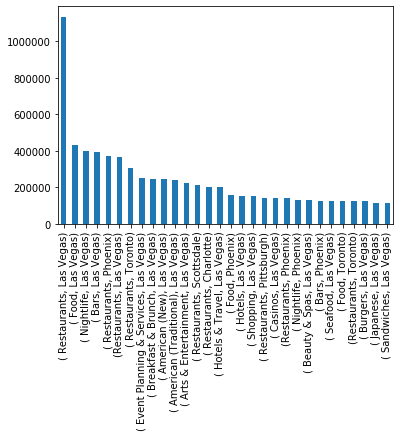

In [32]:
review_business_city = top_num_reviews_for_city_n_biz(df_cleaned,10)
review_business_city[:30].plot(kind = 'bar')

# We want to analyze the city+business with the highest reviews, so 2 candidates could be (restaurants, Las Vegas) and (nightlife, Las Vegas)

In [33]:
rest_lv_reviews = df_cleaned[(df_cleaned.city == 'Las Vegas') & (df_cleaned.categories.str.contains('.Restaurant.', case= False))]
rest_lv_reviews.shape

(1135912, 7)

In [34]:
nl_lv_reviews = df_cleaned[(df_cleaned.city == 'Las Vegas') & (df_cleaned.categories.str.contains('Nightlife', case= False))]
nl_lv_reviews.shape

(503850, 7)

In [35]:
#save them into csv files for further usage
rest_lv_reviews.to_csv('rest_lv_reviews.csv')
nl_lv_reviews.to_csv('nl_lv_reviews.csv')

# Model Building

In [3]:
rest_lv_reviews = pd.read_csv('rest_lv_reviews.csv')

In [4]:
nl_lv_reviews = pd.read_csv('nl_lv_reviews.csv')

In [5]:
def get_clean_df(df, min_user_review = 30, min_res_review = 0, cols = ['user_id', 'business_id', 'rating']):
    '''Cleans the df and gets rid of the unwanted cols and also 
    allows to filter the user and business based on the min number of reviews received'''
    df_new = df[cols]
    df_new.dropna(axis = 0, how = 'any', inplace = True)
    df_new[cols[1]+'_freq'] = df_new.groupby(cols[1])[cols[1]].transform('count')
    df_clean = df_new[df_new[cols[1]+'_freq']>=min_res_review]
    df_clean[cols[0]+'_freq'] = df_clean.groupby(cols[0])[cols[0]].transform('count')
    df_clean_2 = df_clean[df_clean[cols[0]+'_freq']>=min_user_review]
    return df_clean_2

In [6]:
def get_sparsity(sparse_matrix):
    return 1 - sparse_matrix.nnz/(sparse_matrix.shape[0]*sparse_matrix.shape[1])

In [7]:
def get_sparse_matrix(df):
    '''Converts the df into a sparse ratings matrix'''
    unique_users = list(df['user_id'].unique())
    unique_bus = list(df['business_id'].unique())
    data = df['rating'].tolist()
    row = df['user_id'].astype('category').cat.codes
    col = df['business_id'].astype('category').cat.codes
    sparse_matrix = csr_matrix((data, (row, col)), shape=(len(unique_users), len(unique_bus)))
    return sparse_matrix

In [8]:
get_clean_df(rest_lv_reviews, min_user_review=20)

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,user_id,business_id,rating,business_id_freq,user_id_freq
9,WM7MFrRP-7YFuGBAJ6quRQ,d4qwVw4PcN-_2mK2o1Ro1g,4.0,1141,210
10,Y8akYgxl9PkE5LsZxwqRfg,d4qwVw4PcN-_2mK2o1Ro1g,4.0,1141,22
38,iYpP1bb2LN5RJaucO4Azlg,d4qwVw4PcN-_2mK2o1Ro1g,3.0,1141,26
40,uQEqsxqT3U6Ll1dsnqst-w,d4qwVw4PcN-_2mK2o1Ro1g,4.0,1141,23
52,lHFkt91UFwQUywggO8yDHA,d4qwVw4PcN-_2mK2o1Ro1g,2.0,1141,27
...,...,...,...,...,...
1135890,PFENoZUD77aioJGrnllIKA,B3r6Vtl_ND1zF93C2r8BOQ,4.0,3,127
1135898,vwLV4TkRMoghs86tB1Ke8Q,cZrtB-AWUd1BQSGchnTbIw,5.0,6,106
1135899,Mfmx6DSGOrJjr4jeWmqCuw,cZrtB-AWUd1BQSGchnTbIw,5.0,6,226
1135900,cnyCyr5az4YzlQ1oCSYNvQ,cZrtB-AWUd1BQSGchnTbIw,4.0,6,70


In [9]:
#restaurant Las Vegas
u_20_lv = get_sparse_matrix(get_clean_df(rest_lv_reviews, min_user_review=20))
print(get_sparsity(u_20_lv))
print(u_20_lv.shape)

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


0.9916138845539666
(5141, 4716)


In [10]:
#nightlife Las Vegas
u_20_lv_nl = get_sparse_matrix(get_clean_df(nl_lv_reviews, min_user_review=20))
print(get_sparsity(u_20_lv_nl))
print(u_20_lv_nl.shape)

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


0.982418498550576
(1314, 1959)


In [11]:
#filtered by min_user_review=10

user_min_10_lv_res = get_clean_df(rest_lv_reviews, min_user_review=10)
print("Number of Reviews for Restaurants in Las Vegas: ", user_min_10_lv_res.shape[0])

user_min_10_lv_nl = get_clean_df(nl_lv_reviews, min_user_review=10)
print("Number of Reviews for Nightlife in Las Vegas: ", user_min_10_lv_nl.shape[0])

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Number of Reviews for Restaurants in Las Vegas:  352178
Number of Reviews for Nightlife in Las Vegas:  93889


In [12]:
print("Unique Restaurants in Las Vegas =",len(user_min_10_lv_res.business_id.unique()))
print("Unique Users in Las Vegas =",len(user_min_10_lv_res.user_id.unique()))
print("Unique Nightlife in Las Vegas =",len(user_min_10_lv_nl.business_id.unique()))


Unique Restaurants in Las Vegas = 4823
Unique Users in Las Vegas = 15306
Unique Nightlife in Las Vegas = 2086


In [13]:
sm_user_10_lv_rest = get_sparse_matrix(user_min_10_lv_res)
print("Shape of ratings matrix for Restaurants in Las Vegas =",sm_user_10_lv_rest.shape)
sm_user_10_lv_nl = get_sparse_matrix(user_min_10_lv_nl)
print("Shape of ratings matrix for Nightlife in Las Vegas =",sm_user_10_lv_nl.shape)

Shape of ratings matrix for Restaurants in Las Vegas = (15306, 4823)
Shape of ratings matrix for Nightlife in Las Vegas = (4749, 2086)


In [14]:
print("Sparsity of ratings matrix for Restaurants in Las Vegas = ", get_sparsity(sm_user_10_lv_rest))
print("Sparsity of ratings matrix for Nightlife in Las Vegas = ", get_sparsity(sm_user_10_lv_nl))


Sparsity of ratings matrix for Restaurants in Las Vegas =  0.9955267373150113
Sparsity of ratings matrix for Nightlife in Las Vegas =  0.9911808652454864


In [15]:
def train_val_test_split(sparse_matrix, num_review_val = 2, num_review_test = 2):
    '''Split the rating matrix into train ,val, and test marix that are disjoint matrices'''
    nzrows, nzcols =  sparse_matrix.nonzero()
    sparse_matrix_test = csr_matrix(sparse_matrix.shape)
    sparse_matrix_val = csr_matrix(sparse_matrix.shape)
    sparse_matrix_train = sparse_matrix.copy()
    n_users = sparse_matrix.shape[0]
    for u in range(n_users):
        idx = nzcols[np.where(nzrows == u)]
        np.random.shuffle(idx)
        test_idx = idx[-num_review_test:]
        val_idx = idx[-(num_review_val+num_review_test):-num_review_test]
        train_idx = idx[:-(num_review_val+num_review_test)]
        sparse_matrix_test[u,test_idx] = sparse_matrix[u,test_idx]
        sparse_matrix_val[u,val_idx] = sparse_matrix[u,val_idx]
        sparse_matrix_train[u,test_idx] = 0
        sparse_matrix_train[u,val_idx] = 0
    data = np.array(sparse_matrix_train[sparse_matrix_train.nonzero()])[0]
    row = sparse_matrix_train.nonzero()[0]
    col = sparse_matrix_train.nonzero()[1]
    size = sparse_matrix_train.shape
    sparse_matrix_train = csr_matrix((data,(row,col)),shape = size)
    mult = sparse_matrix_train.multiply(sparse_matrix_val)
    mmult = mult.multiply(sparse_matrix_test)
    assert(mmult.nnz == 0)
    return sparse_matrix_train, sparse_matrix_val, sparse_matrix_test

In [16]:
#train,test,validation split

sm_u_10_lv_res_train, sm_u_10_lv_res_val, sm_u_10_lv_res_test = train_val_test_split(sm_user_10_lv_rest)
sm_u_10_lv_nl_train, sm_u_10_lv_nl_val, sm_u_10_lv_nl_test =  train_val_test_split(sm_user_10_lv_nl)

/Applications/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:118: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
/Applications/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:118: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


In [17]:
print(sm_u_10_lv_res_train.nnz, sm_u_10_lv_res_val.nnz, sm_u_10_lv_res_test.nnz)
print(sm_u_10_lv_nl_train.nnz, sm_u_10_lv_nl_val.nnz, sm_u_10_lv_nl_test.nnz)

269001 30607 30612
68376 9493 9497


In [18]:
train_lv_nnz = sm_u_10_lv_res_train.nonzero()
val_lv_nnz = sm_u_10_lv_res_val.nonzero()
test_lv_nnz = sm_u_10_lv_res_test.nonzero()

# Neural Network Model

In [19]:
import numpy as np

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import random
import matplotlib.pyplot as plt
import pickle

In [20]:
#SGD with bias correction

def sgd(ratings, k=5, user_bias_reg = 0.01, res_bias_reg = 0.01, user_vec_reg = 0.01, res_vec_reg = 0.01, lr = 1e-3, 
       iterations = 5):
    '''Learn user and res biases along with latent vectors'''
    error_array = np.zeros(iterations);
    global_bias = np.mean(ratings[np.where(ratings)!=0])
    user_bias = 0.1*(2*(np.random.rand(ratings.shape[0]))-1)
    res_bias = 0.1*(2*(np.random.rand(ratings.shape[1]))-1)
    user_vec = 0.1*(2*(np.random.rand(ratings.shape[0],k))-1)
    res_vec = 0.1*(2*(np.random.rand(ratings.shape[1],k))-1)
    training_idx = np.arange(ratings.nonzero()[0].shape[0])
    np.random.shuffle(training_idx)
    nz_rows_idx = ratings.nonzero()[0]
    nz_cols_idx = ratings.nonzero()[1]
    for i in range(iterations):
    
#         if(i%20 == 0):
#             print('Iteration number: ', i)
        lr = 1.0/(100 + 0.01*i)
        np.random.shuffle(training_idx)
        
        temp_error_array = np.zeros(len(training_idx));
        for datapoint_i, idx in enumerate(training_idx):
            u = nz_rows_idx[idx]
            r = nz_cols_idx[idx]
            prediction = global_bias + user_bias[u] + res_bias[r] + np.dot(user_vec[u,:], res_vec[r,:].T)
            e = (ratings[u,r] - prediction);
            temp_error_array[datapoint_i] += e**2;
            if i > 0:
                user_bias[u] += lr * (e - user_bias_reg * user_bias[u])
                res_bias[r] += lr * (e - res_bias_reg * res_bias[r])
                user_vec[u,:] += lr * (e * res_vec[r,:] - user_vec_reg * user_vec[u,:])
                res_vec[r,:] += lr * (e * user_vec[u,:] - res_vec_reg * res_vec[r,:])
            
        error_array[i] = np.mean(temp_error_array);
#         print(error_array[i])
            
    predictions = global_bias + user_bias[:, np.newaxis] + res_bias[np.newaxis, :] + np.dot(user_vec, res_vec.T)
    predictions[predictions > 5] = 5
    predictions[predictions < 0] = 0
    
    return (predictions, error_array, user_vec, res_vec)

In [21]:
#get mse function

def get_mse(pred, actual):
    # Ignore zero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)

In [22]:
#predictions_sgd_lv, error_array_sgd_lv, user_vec_sgd_lv, res_vec_sgd_lv = 
predictions_sgd_lv, error_array_sgd_lv, user_vec_sgd_lv, res_vec_sgd_lv=sgd(np.array(sm_u_10_lv_res_train.todense()))


In [23]:
def concatenated_SGD(U, V, matrix):
    '''Concatenates the User Vector U (n_u x k) and Res Vector V (n_r x K) and returns a matrix of \ 
    2k+1 x number of non-zero ratings in rating matrix (matrix)'''
    indexes=matrix.nonzero()
    users=U[indexes[0]]
    rest=V[indexes[1]]
    ratings=matrix[indexes].T
    concat_sgd=np.concatenate((users,rest,ratings),axis=1)
    return concat_sgd

In [24]:
train_lv_res = concatenated_SGD(user_vec_sgd_lv, res_vec_sgd_lv, sm_u_10_lv_res_train)
val_lv_res = concatenated_SGD(user_vec_sgd_lv, res_vec_sgd_lv, sm_u_10_lv_res_val)
test_lv_res = concatenated_SGD(user_vec_sgd_lv, res_vec_sgd_lv, sm_u_10_lv_res_test)

In [25]:
train_mat_lv_res = np.array(train_lv_res);
val_mat_lv_res = np.array(val_lv_res);
test_mat_lv_res = np.array(test_lv_res);

In [27]:
x_train, y_train = train_mat_lv_res[:, :-1], np.ravel(train_mat_lv_res[:,-1]);
x_val, y_val = val_mat_lv_res[:, :-1], np.ravel(val_mat_lv_res[:, -1])

In [29]:
n_iteration = 1000;
plot_freq = 100;
a,b = 100, 0.01;
batch_size = 18902; #set to -1 for entire train set
# batch_size = 5;
weight_decay = 0.1;

k = x_train.shape[1];
#load objects here
max_batch_size = x_train.shape[0];
if(batch_size == -1):
    batch_size = max_batch_size;
#assert(max_batch_size % batch_size == 0);
no_of_batches = int(max_batch_size/batch_size);

In [33]:
def get_torch_var(x):
        return(Variable(torch.Tensor( x )))

In [34]:
class Net(nn.Module):

    def __init__(self, k):
        super(Net, self).__init__()
        self.k = k;
        self.linear1 = nn.Linear(k, 2, bias = True);
        self.linear2 = nn.Linear(2, 1, bias = True);

    def forward(self, x):
        l_1 = self.linear1(x);
        n_1 = F.sigmoid(l_1);
        l_2 = self.linear2(n_1);
        out = F.relu(l_2);
        return out

net = Net(k)

optimizer = optim.Adam(net.parameters(), weight_decay=weight_decay);
criterion = nn.MSELoss()

loss_array = np.zeros(n_iteration);
val_array = np.zeros(n_iteration);

In [36]:
train_preds_nn_lv = np.ravel(net(get_torch_var(x_train)).data.numpy())
val_preds_nn_lv = np.ravel(net(get_torch_var(x_val)).data.numpy())
test_preds_nn_lv = np.ravel(net(get_torch_var(test_mat_lv_res[:, :-1])).data.numpy())

the results from the previous cell are all 0s, it might because we have a quite sparse matrix; this model is not performing as I expected, and I need more knowledge in neural network to build a neural network model for a recommender system

# Cosine Similarity with correction for bias

In [46]:
def similarity_matrix(train_matrix, between = 'users'):
    '''Returns the cosine similarity between users or restaurants'''
    if between == 'users':
        similarity = train_matrix*train_matrix.transpose()
    else:
        similarity = train_matrix.transpose()*train_matrix
    similarity_dense = similarity.todense() + 1e-8
    norm_array = np.sqrt(np.diag(similarity_dense))
    return similarity_dense/norm_array/norm_array.reshape(-1,1)

In [47]:
def predict_topk_nobias(ratings, similarity, kind='user', k=40):
    pred = np.zeros(ratings.shape)
    if kind == 'user':
        user_bias = np.mean(ratings, axis =1)
        ratings = (ratings - np.tile(user_bias, (ratings.shape[1],1)).T).copy()
        for i in range(ratings.shape[0]):
            top_k_users = np.argsort(similarity[:,i])[:-k-1:-1]
            pred[i] = np.dot(similarity[i,top_k_users],ratings[top_k_users,:])/np.sum(np.abs(similarity[i,top_k_users]))
        pred += np.tile(user_bias,(ratings.shape[1],1)).T
    else:
        item_bias = np.mean(ratings, axis=0)
        ratings = (ratings - np.tile(item_bias,(ratings.shape[0],1))).copy()
        for j in range(ratings.shape[1]):
            top_k_items = np.argsort(similarity[:,j])[:-k-1:-1]
            pred[:,j] = np.dot(similarity[top_k_items,j].T,ratings[:,top_k_items].T)/np.sum(np.abs(similarity[top_k_items,j]))
        pred += np.tile(item_bias,(ratings.shape[0],1))
        
    return pred

In [48]:
simi_lv_res = similarity_matrix(sm_u_10_lv_res_train, between='res')
simi_lv_res = np.array(simi_lv_res)
preds_cosine_lv = predict_topk_nobias(np.array(sm_u_10_lv_res_train.todense()),simi_lv_res,kind='res', k=1)
MSE_cosine_res = get_mse(preds_cosine_lv, np.array(sm_u_10_lv_res_val.todense()))
print("MSE for cosine Similarity between Restaurants =",MSE_cosine_res)

MSE for cosine Similarity between Restaurants = 19.677851471885518


In [49]:
simi_lv_users = similarity_matrix(sm_u_10_lv_res_train, between='users')
simi_lv_users = np.array(simi_lv_users)
preds_cosine_lv_users = predict_topk_nobias(np.array(sm_u_10_lv_res_train.todense()),simi_lv_users,kind='user', k=1)
MSE_cosine_users = get_mse(preds_cosine_lv_users, np.array(sm_u_10_lv_res_val.todense()))
print("MSE for cosine Similarity between Users =",MSE_cosine_users)

MSE for cosine Similarity between Users = 19.677851471885518


In [50]:
simi_lv_res = similarity_matrix(sm_u_10_lv_res_train, between='res')
simi_lv_res = np.array(simi_lv_res)
preds_cosine_lv = predict_topk_nobias(np.array(sm_u_10_lv_res_train.todense()),
                                      simi_lv_res,kind='res', k=40)
Best_Val_MSE_Cosine_lv = get_mse(preds_cosine_lv, np.array(sm_u_10_lv_res_val.todense()))
print('Best Validation MSE for Cosine Similarity for Restaurants in Las Vegas= ', 
      Best_Val_MSE_Cosine_lv)

Best Validation MSE for Cosine Similarity for Restaurants in Las Vegas=  18.756374795241868
